In [39]:
# Step 1. Load and inspect the climate dataset
import pandas as pd

# Load the Excel file - change sheet_name if needed
file_path = "2025 Allianz Datathon Dataset.xlsx"

# Load the "Climate Data" sheet WITHOUT pre-selecting columns
climate_df = pd.read_excel(file_path, sheet_name="Climate Data")

# Strip any column name spaces
climate_df.columns = climate_df.columns.str.strip()

print("\nDataFrame Info:")
print(climate_df.info())
print("\nFirst 5 rows:")
print(climate_df.head())


# Load the climate sheet
climate_df = pd.read_excel(file_path, sheet_name="Climate Data")

# Show basic info




# Quick check for missing values
print("\nMissing values per column:")
print(climate_df.isnull().sum())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39813 entries, 0 to 39812
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Bureau of Meteorology station number  39813 non-null  int64  
 1   Year                                  39813 non-null  int64  
 2   Month                                 39813 non-null  int64  
 3   Day                                   39813 non-null  int64  
 4   Maximum temperature (Degree C)        38275 non-null  float64
 5   Minimum temperature (Degree C)        38280 non-null  float64
 6   Rainfall amount (millimetres)         37857 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.1 MB
None

First 5 rows:
   Bureau of Meteorology station number  Year  Month  Day  \
0                                 71075  2010      1    1   
1                                 71075  2010      1    2   
2                  

In [40]:
print(climate_df.columns.tolist())

['Bureau of Meteorology station number', 'Year', 'Month', 'Day', 'Maximum temperature (Degree C)', 'Minimum temperature (Degree C)', 'Rainfall amount (millimetres)']


In [41]:
# Step 2 — Clean & prepare the time series (drop missing rows)

# 1) Create a proper Date column
climate_df['Date'] = pd.to_datetime(climate_df[['Year', 'Month', 'Day']], errors='coerce')

# 2) Drop unused columns
climate_df = climate_df.drop(columns=['Bureau of Meteorology station number', 'Year', 'Month', 'Day'])

# 3) Set Date as index and sort
climate_df = climate_df.set_index('Date').sort_index()

# 4) Drop any rows with missing values
climate_clean = climate_df.dropna()

# 5) Sanity check
print(climate_clean.info())
print("\nFirst 5 rows:")
print(climate_clean.head())
print("\nRemaining missing values per column:")
print(climate_clean.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36820 entries, 2010-01-01 to 2025-07-28
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Maximum temperature (Degree C)  36820 non-null  float64
 1   Minimum temperature (Degree C)  36820 non-null  float64
 2   Rainfall amount (millimetres)   36820 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB
None

First 5 rows:
            Maximum temperature (Degree C)  Minimum temperature (Degree C)  \
Date                                                                         
2010-01-01                            14.5                            10.3   
2010-01-01                            17.6                            10.7   
2010-01-01                            16.3                            10.3   
2010-01-01                            20.9                            12.2   
2010-01-01                            17.6

Decomposition period set to: 365


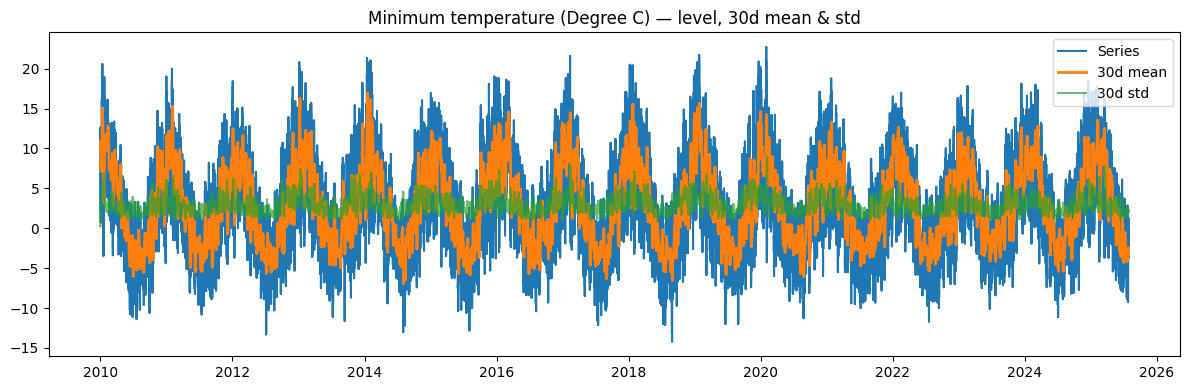

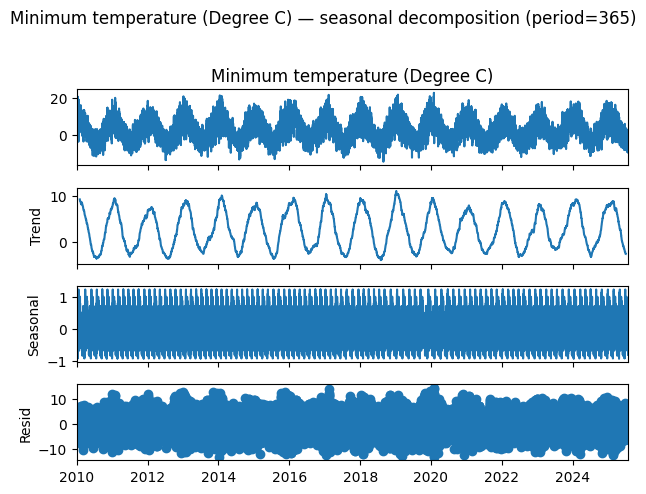

<Figure size 1200x380 with 0 Axes>

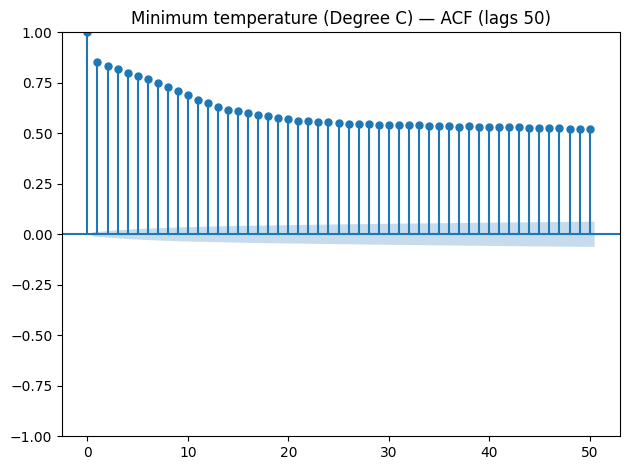

<Figure size 1200x380 with 0 Axes>

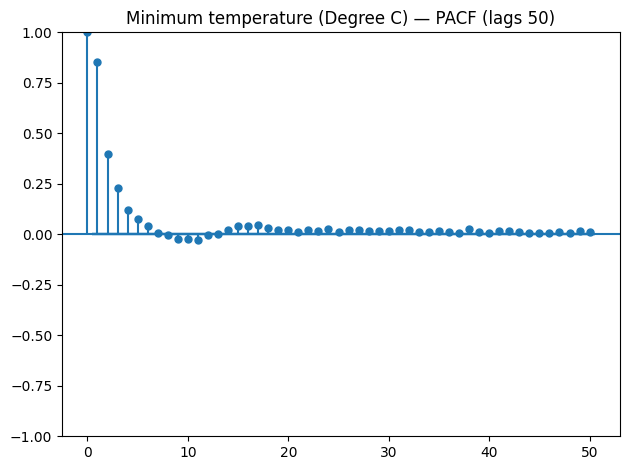

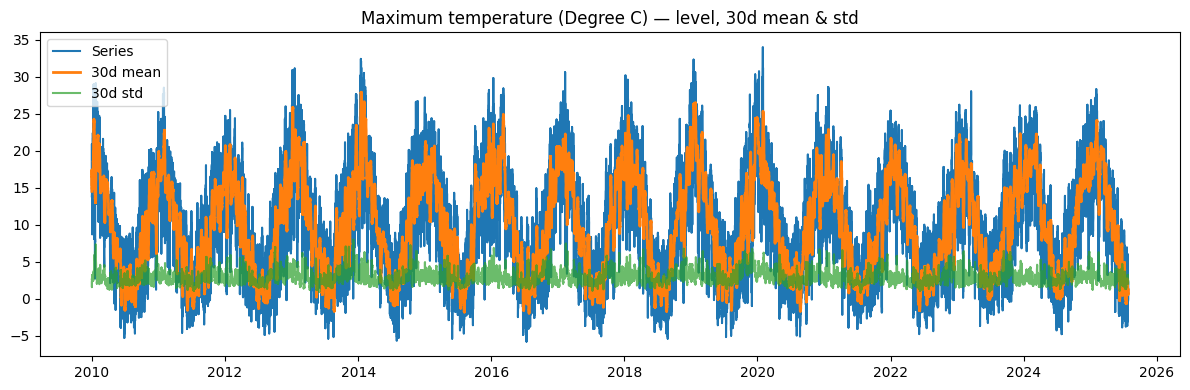

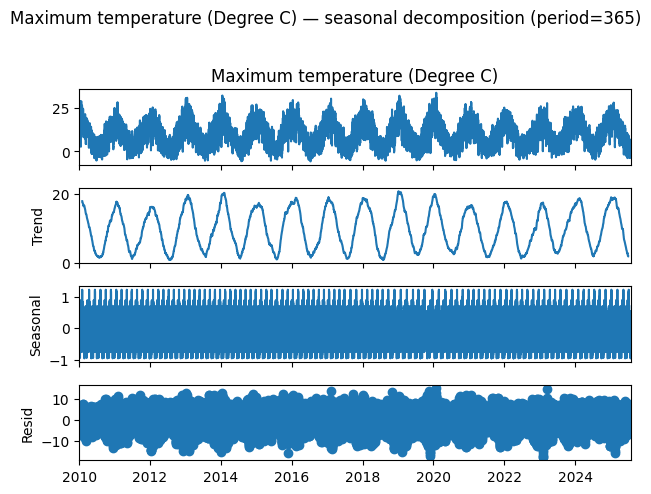

<Figure size 1200x380 with 0 Axes>

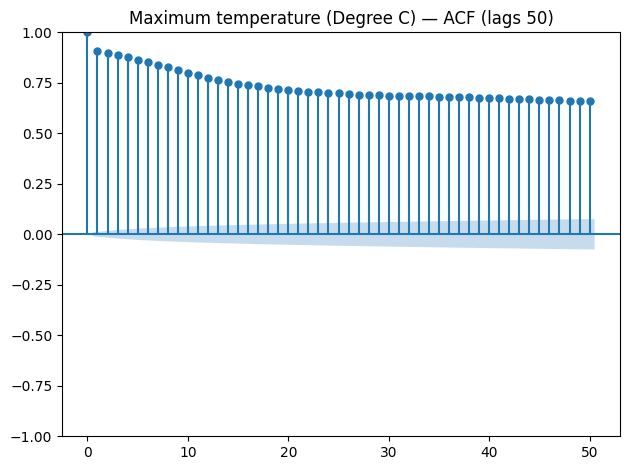

<Figure size 1200x380 with 0 Axes>

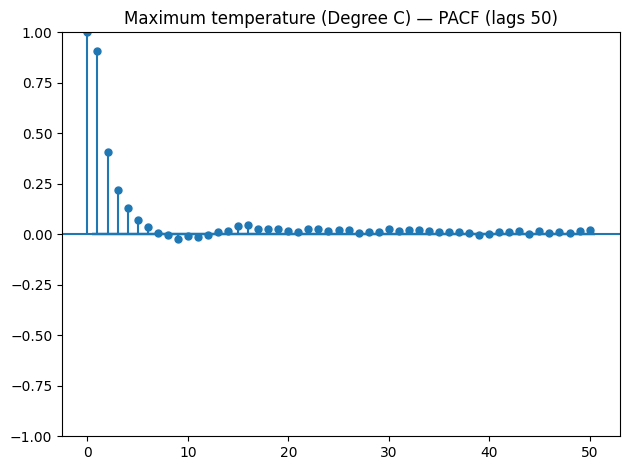

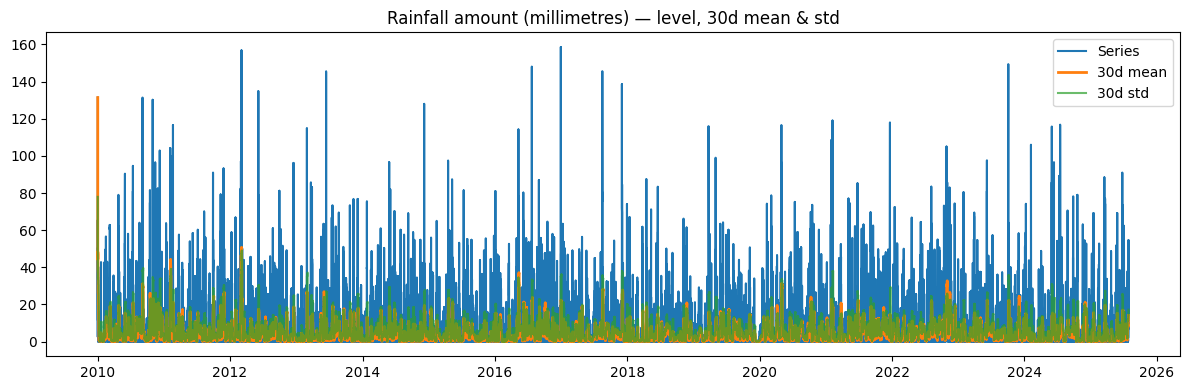

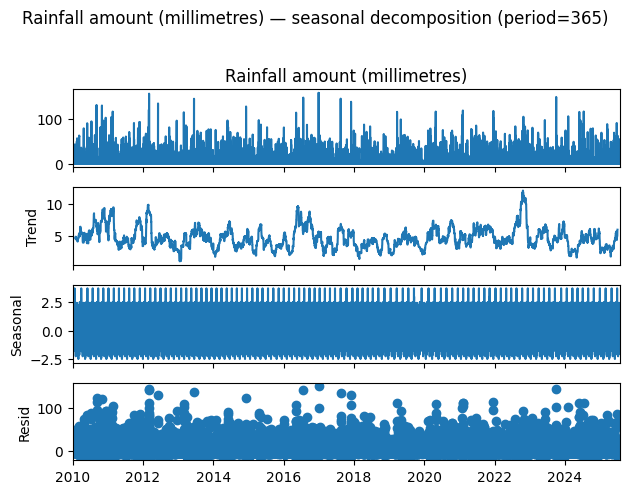

<Figure size 1200x380 with 0 Axes>

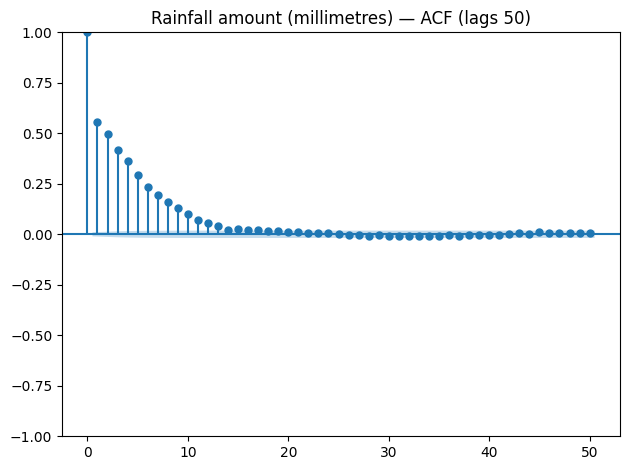

<Figure size 1200x380 with 0 Axes>

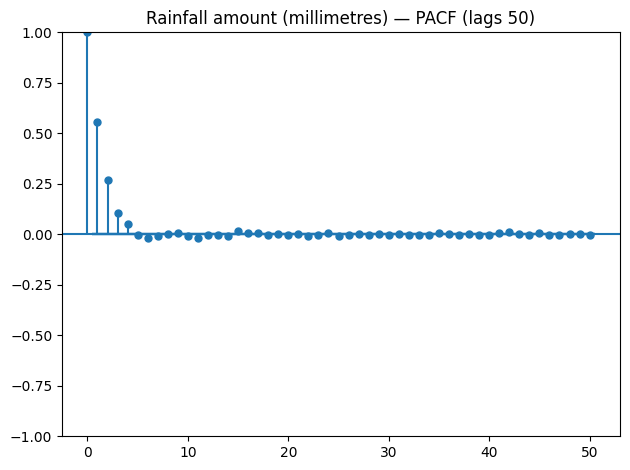


Augmented Dickey-Fuller (level):


,series,n,ADF stat,p-value,lags used,critical 1%,critical 5%,critical 10%
0,Minimum temperature (Degree C),36820,-9.829241,5.089366e-17,52,-3.430528,-2.861619,-2.566812
1,Maximum temperature (Degree C),36820,-7.783228,8.309755e-12,53,-3.430528,-2.861619,-2.566812
2,Rainfall amount (millimetres),36820,-40.386306,0.000000e+00,14,-3.430528,-2.861619,-2.566812


<Figure size 1000x400 with 0 Axes>

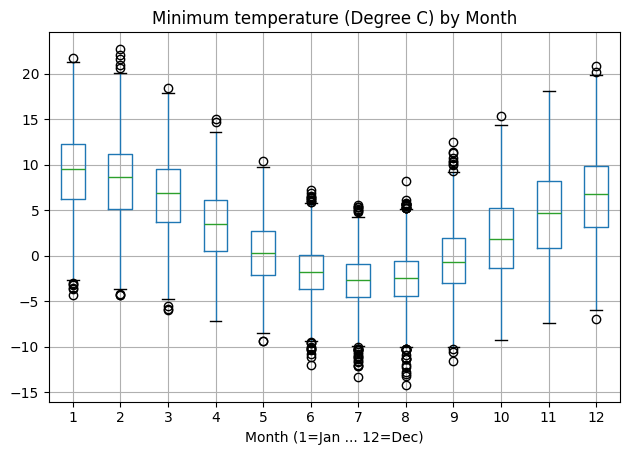

<Figure size 1000x400 with 0 Axes>

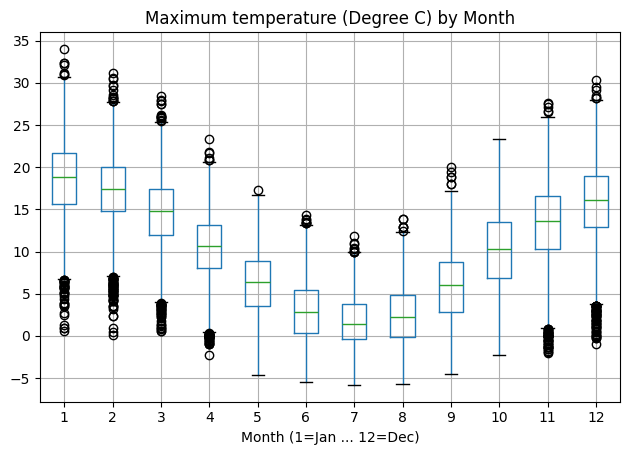

<Figure size 1000x400 with 0 Axes>

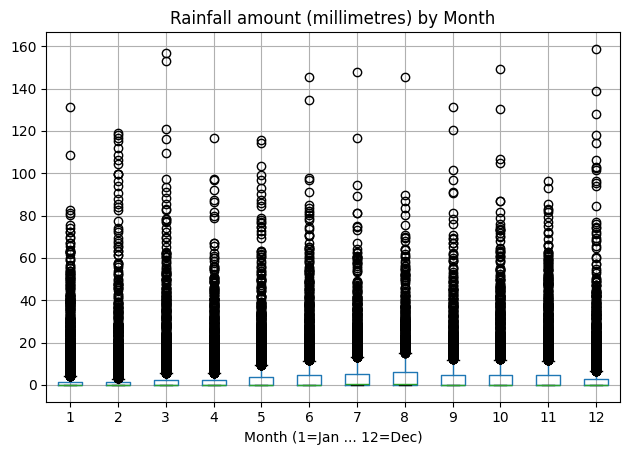


Ski season (Jun–Aug) quick stats:


,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
count,9524.000000,9524.000000,9524.000000
mean,-2.354473,2.491789,5.019131
std,2.834287,3.263914,10.624260
min,-14.200000,-5.800000,0.000000
25%,-4.200000,0.000000,0.000000
50%,-2.300000,2.100000,0.400000
75%,-0.500000,4.700000,5.200000
max,8.200000,14.300000,148.000000


In [42]:
# Step 3 — EDA for Min/Max Temp and Rainfall

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# --- CONFIG ---
df = climate_clean.copy()  # expects Date index
cols = [
    'Minimum temperature (Degree C)',
    'Maximum temperature (Degree C)',
    'Rainfall amount (millimetres)'
]

# Helper: pick a decomposition period
def pick_period(index: pd.DatetimeIndex) -> int:
    # Daily data → weekly seasonality as baseline; try yearly if long series
    days = (index.max() - index.min()).days
    return 365 if days >= 730 else 7

period = pick_period(df.index)
print(f"Decomposition period set to: {period}")

# Helper: ADF summary
def adf_summary(series, name):
    s = series.dropna().astype(float)
    res = adfuller(s, autolag='AIC')
    out = {
        'series': name,
        'n': len(s),
        'ADF stat': res[0],
        'p-value': res[1],
        'lags used': res[2],
        'critical 1%': res[4]['1%'],
        'critical 5%': res[4]['5%'],
        'critical 10%': res[4]['10%'],
    }
    return out

adf_rows = []

for c in cols:
    s = df[c].astype(float)

    # 1) Line plot with rolling stats
    plt.figure(figsize=(12,4))
    plt.plot(s, label='Series')
    plt.plot(s.rolling(30, min_periods=1).mean(), label='30d mean', linewidth=2)
    plt.plot(s.rolling(30, min_periods=1).std(), label='30d std', alpha=0.7)
    plt.title(f"{c} — level, 30d mean & std")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Seasonal decomposition (may fail if series too short for chosen period)
    try:
        decomp = seasonal_decompose(s.dropna(), model='additive', period=period)
        decomp.plot()
        plt.suptitle(f"{c} — seasonal decomposition (period={period})", y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Decomposition skipped for {c}: {e}")

    # 3) ACF / PACF (use diff if needed to avoid huge scales)
    plt.figure(figsize=(12,3.8))
    plot_acf(s.dropna(), lags=50)
    plt.title(f"{c} — ACF (lags 50)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.8))
    plot_pacf(s.dropna(), lags=50, method='ywm')
    plt.title(f"{c} — PACF (lags 50)")
    plt.tight_layout()
    plt.show()

    # 4) Stationarity test (ADF)
    adf_rows.append(adf_summary(s, c))

# ADF results table
adf_table = pd.DataFrame(adf_rows)
print("\nAugmented Dickey-Fuller (level):")
display(adf_table)

# 5) Seasonal boxplots by month (helpful for winter planning)
df_monthly = df.copy()
df_monthly['Month'] = df_monthly.index.month

for c in cols:
    plt.figure(figsize=(10,4))
    df_monthly.boxplot(column=c, by='Month')
    plt.title(f"{c} by Month")
    plt.suptitle("")  # remove pandas default big title
    plt.xlabel("Month (1=Jan ... 12=Dec)")
    plt.tight_layout()
    plt.show()

# 6) Optional: focus on Australian ski season (Jun–Aug)
ski_season = df[(df.index.month >= 6) & (df.index.month <= 8)][cols]
print("\nSki season (Jun–Aug) quick stats:")
display(ski_season.describe())


=== WEEKLY MAX TEMP ===
Best AIC 2110.3 with (0, 1, 0) x (0, 1, 0, 52)
Best AIC 1710.5 with (0, 1, 0) x (0, 1, 1, 52)
Best AIC 1527.1 with (0, 1, 1) x (0, 1, 1, 52)
Best AIC 1526.8 with (2, 1, 1) x (0, 1, 1, 52)


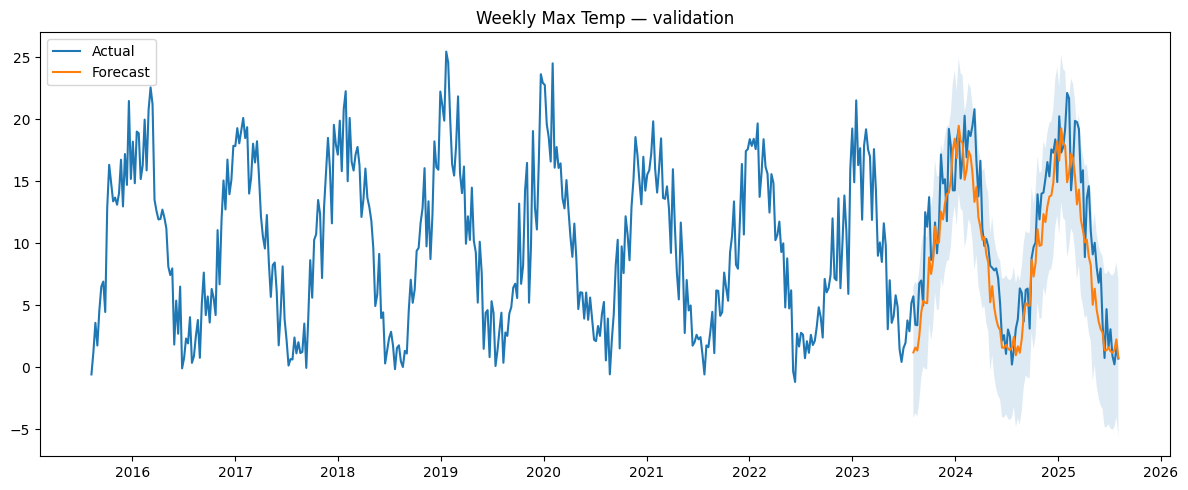

MAE=2.572  RMSE=3.131


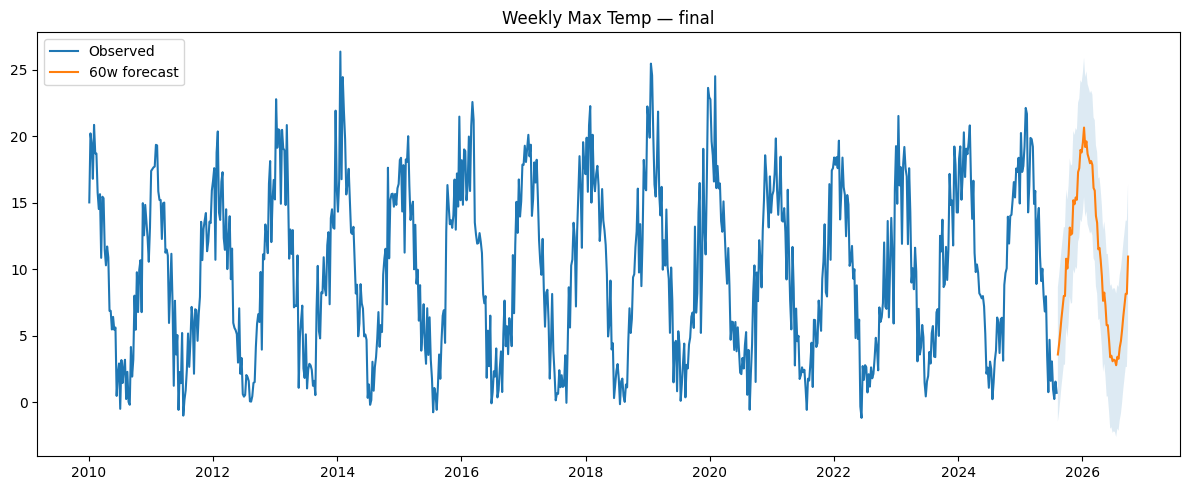


=== WEEKLY MIN TEMP ===
Best AIC 2002.1 with (0, 1, 0) x (0, 1, 0, 52)
Best AIC 1615.9 with (0, 1, 0) x (0, 1, 1, 52)
Best AIC 1416.5 with (0, 1, 1) x (0, 1, 1, 52)


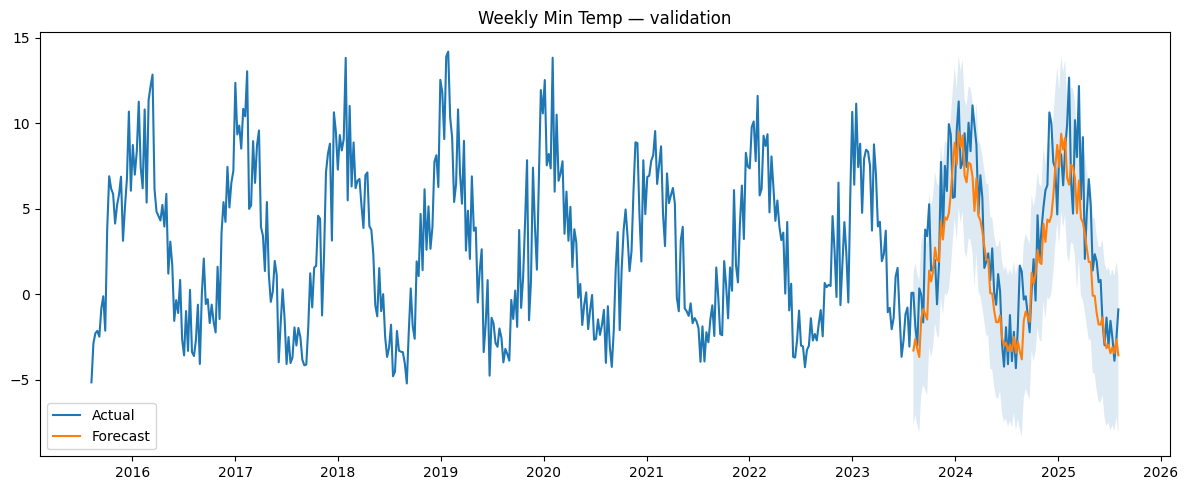

MAE=2.017  RMSE=2.566


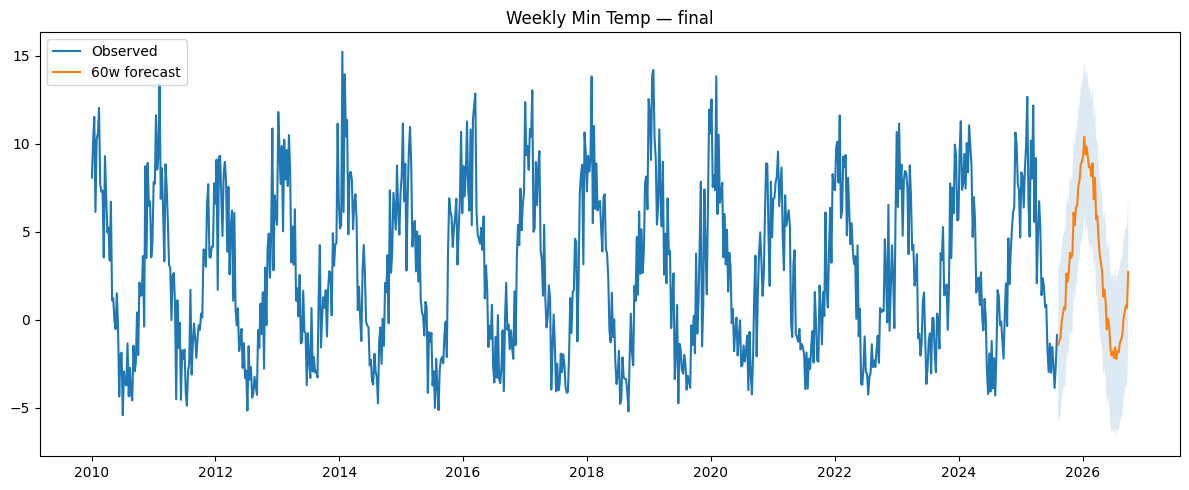


=== WEEKLY RAINFALL (log1p) ===
Best AIC 1729.9 with (0, 1, 0) x (0, 1, 0, 52)
Best AIC 1302.3 with (0, 1, 0) x (0, 1, 1, 52)
Best AIC 1106.9 with (0, 1, 1) x (0, 1, 1, 52)
Best AIC 1103.5 with (2, 1, 1) x (0, 1, 1, 52)


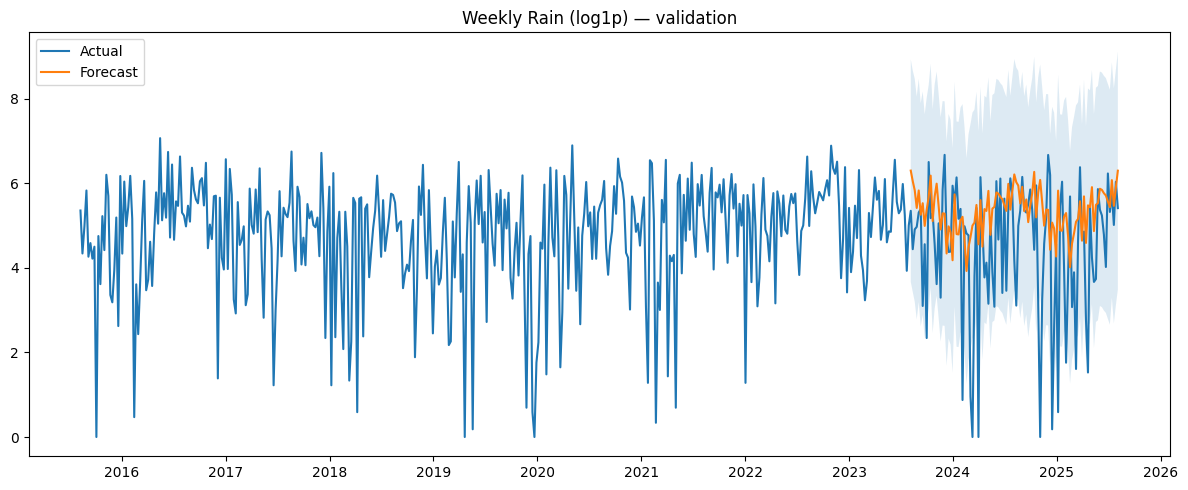

MAE=168.587  RMSE=210.638


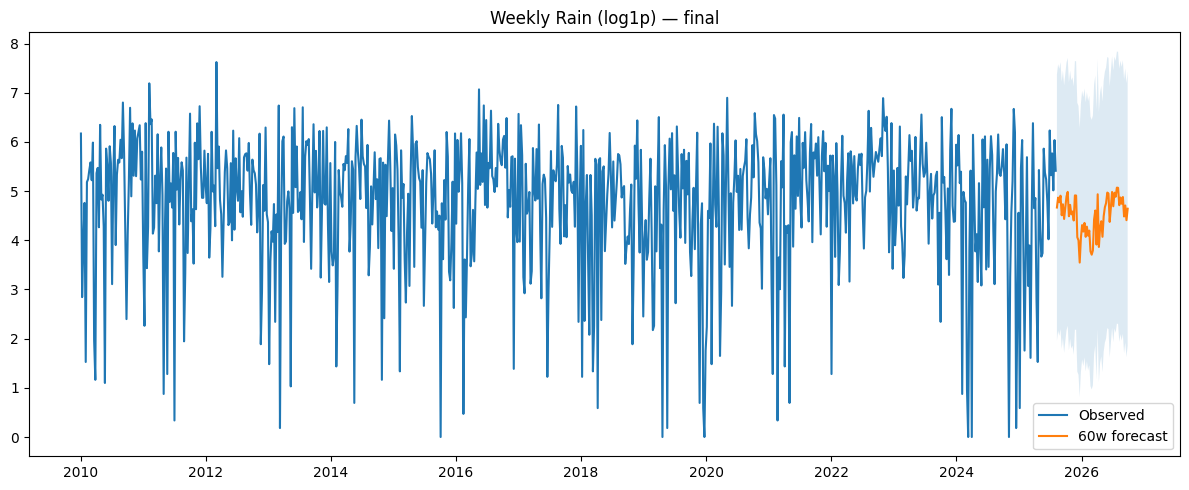

In [43]:
# Ensure we have the cleaned dataframe
if "climate_clean" not in globals():
    climate_df['Date'] = pd.to_datetime(climate_df.index)  # if not already done
    climate_df = climate_df.sort_index()
    climate_clean = climate_df.dropna()

# Step 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import gc

# ---------- Prep weekly data (mean temps, sum rainfall)
col_max = 'Maximum temperature (Degree C)'
col_min = 'Minimum temperature (Degree C)'
col_rain = 'Rainfall amount (millimetres)'

wk = pd.DataFrame({
    'MaxTemp': climate_clean[col_max],
    'MinTemp': climate_clean[col_min],
    'Rain':    climate_clean[col_rain]
})
wk = wk.resample('W').agg({'MaxTemp':'mean','MinTemp':'mean','Rain':'sum'}).asfreq('W')

# Optional: limit search sample to recent 10 years to speed up search
search_start = wk.index.max() - pd.DateOffset(years=10)
wk_search = wk.loc[search_start:].copy()

def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

def fit_best_sarima(y, m=52,
                    p_vals=(0,1,2), d=1, q_vals=(0,1),
                    P_vals=(0,1), D=1, Q_vals=(0,1),
                    verbose=True):
    y = y.dropna().astype(float)
    best = {"aic": np.inf, "order": None, "seasonal_order": None, "res": None}
    for p in p_vals:
        for q in q_vals:
            for P in P_vals:
                for Q in Q_vals:
                    order = (p, d, q)
                    sorder = (P, D, Q, m)
                    try:
                        res = SARIMAX(y, order=order, seasonal_order=sorder,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit(disp=False)
                        if res.aic < best["aic"]:
                            best = {"aic": res.aic, "order": order, "seasonal_order": sorder, "res": res}
                            if verbose:
                                print(f"Best AIC {res.aic:.1f} with {order} x {sorder}")
                    except Exception:
                        pass
                    finally:
                        # help GC between fits
                        try:
                            del res
                        except:
                            pass
                        gc.collect()
    return best

def validate_and_plot(y, res, steps, title):
    fc = res.get_forecast(steps=steps)
    mean = fc.predicted_mean
    ci = fc.conf_int()

    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label="Actual")
    plt.plot(mean.index, mean, label="Forecast")
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.15)
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show(); plt.close('all')
    return mean, ci

def refit_full_and_forecast(y_full, order, sorder, steps, title):
    res = SARIMAX(y_full, order=order, seasonal_order=sorder,
                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fc = res.get_forecast(steps=steps)
    mean, ci = fc.predicted_mean, fc.conf_int()
    plt.figure(figsize=(12,5))
    plt.plot(y_full.index, y_full, label='Observed')
    plt.plot(mean.index, mean, label=f'{steps}w forecast')
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.15)
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show(); plt.close('all')
    return mean, ci, res

# ---------- MAX TEMP (weekly mean)
print("\n=== WEEKLY MAX TEMP ===")
y = wk_search['MaxTemp'].astype(float)
split = int(len(y)*0.8); y_tr, y_te = y.iloc[:split], y.iloc[split:]
best_max = fit_best_sarima(y_tr, m=52)
yh, _ = validate_and_plot(pd.concat([y_tr, y_te]), best_max['res'], len(y_te),
                          "Weekly Max Temp — validation")
print(f"MAE={mae(y_te, yh):.3f}  RMSE={rmse(y_te, yh):.3f}")
fc_max_w, ci_max_w, res_max_full = refit_full_and_forecast(
    wk['MaxTemp'].astype(float), best_max['order'], best_max['seasonal_order'], 60, "Weekly Max Temp — final"
)

# ---------- MIN TEMP (weekly mean)
print("\n=== WEEKLY MIN TEMP ===")
y = wk_search['MinTemp'].astype(float)
split = int(len(y)*0.8); y_tr, y_te = y.iloc[:split], y.iloc[split:]
best_min = fit_best_sarima(y_tr, m=52)
yh, _ = validate_and_plot(pd.concat([y_tr, y_te]), best_min['res'], len(y_te),
                          "Weekly Min Temp — validation")
print(f"MAE={mae(y_te, yh):.3f}  RMSE={rmse(y_te, yh):.3f}")
fc_min_w, ci_min_w, res_min_full = refit_full_and_forecast(
    wk['MinTemp'].astype(float), best_min['order'], best_min['seasonal_order'], 60, "Weekly Min Temp — final"
)

# ---------- RAINFALL (weekly sum, log1p)
print("\n=== WEEKLY RAINFALL (log1p) ===")
y = np.log1p(wk_search['Rain'].astype(float))
split = int(len(y)*0.8); y_tr, y_te = y.iloc[:split], y.iloc[split:]
best_rain = fit_best_sarima(y_tr, m=52, p_vals=(0,1,2), q_vals=(0,1))
yh_log, _ = validate_and_plot(pd.concat([y_tr, y_te]), best_rain['res'], len(y_te),
                              "Weekly Rain (log1p) — validation")
print(f"MAE={mae(np.expm1(y_te), np.expm1(yh_log)):.3f}  RMSE={rmse(np.expm1(y_te), np.expm1(yh_log)):.3f}")
fc_rain_w_log, ci_rain_w_log, res_rain_full = refit_full_and_forecast(
    np.log1p(wk['Rain'].astype(float)), best_rain['order'], best_rain['seasonal_order'], 60, "Weekly Rain (log1p) — final"
)
fc_rain_w = np.expm1(fc_rain_w_log)
ci_rain_w = np.expm1(ci_rain_w_log)

In [45]:
# --- Extract hottest & coldest weeks from SARIMA forecasts ---

# Use your forecast series (adjust names if you used daily instead of weekly)
# fc_max_w = weekly max temp forecast (pandas Series, indexed by Date)
# fc_min_w = weekly min temp forecast

# Restrict to 2026 only
fc_max_2026 = fc_max_w[fc_max_w.index.year == 2026]
fc_min_2026 = fc_min_w[fc_min_w.index.year == 2026]

# Find hottest week (highest MaxTemp)
hottest_week = fc_max_2026.idxmax()
hottest_value = fc_max_2026.max()

# Find coldest week (lowest MinTemp)
coldest_week = fc_min_2026.idxmin()
coldest_value = fc_min_2026.min()

print("Hottest week in 2026:")
print(f"Date: {hottest_week}, Forecast Max Temp: {hottest_value:.2f}°C")

print("\nColdest week in 2026:")
print(f"Date: {coldest_week}, Forecast Min Temp: {coldest_value:.2f}°C")

Hottest week in 2026:
Date: 2026-01-11 00:00:00, Forecast Max Temp: 20.64°C

Coldest week in 2026:
Date: 2026-07-19 00:00:00, Forecast Min Temp: -2.24°C
